In [1]:
from torchtext.datasets import AG_NEWS


## Token and Vocab

In [2]:

# Have to make the dataset iterable
train_iter = iter(AG_NEWS(split = 'train'))

# Set the tokenizer and the vocab
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

# set the vocab
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator([tokenizer(sample) for _,sample in train_iter],specials = ["<unk>"])
vocab.set_default_index(vocab["<unk>"])

print(f"Length of the vocabulary: {len(vocab)}")
print(f"Some of the tokenized words: {list(vocab.get_stoi().keys())[:10]}")

Length of the vocabulary: 95811
Some of the tokenized words: ['zyprexa', 'zwiki', 'zurab', 'zuhua', 'zubrin', 'zovko', 'zotinca', 'zos', 'zoology', 'zoner']


## Create the dataset


In [3]:
train_iter, test_iter = AG_NEWS()

# Creating train and validation iterable dataset
train_iter,test_iter = AG_NEWS()

# Converting the iterable dataset into map style dataset
from torchtext.data.functional import to_map_style_dataset
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Splitting the train data into train and validation dataset, Where 95% contains train data and rest of them contain validation data
train_size = int(len(train_dataset) * 0.95)

# for randomly splitting we use the function random_split
from torch.utils.data.dataset import random_split
train_data,validation_data = random_split(train_dataset,[train_size,len(train_dataset) - train_size])

In [4]:
len(train_data),len(validation_data)

(114000, 6000)

In [5]:
label,text = next(iter(train_data))

In [6]:
label,text

(2,
 'Petrova upends Henin-Hardenne Justine Henin-Hardenne looked up at the scoreboard that showed her opponent, Russian Nadia Petrova, leading by a set and a break. Then ')

In [25]:
# AG_NEWS label
ag_news_label = {1:'World',2:'Sports',3:'Business',4:'Sci/Tech'}

## Create DataLoader

In [7]:
# text_pipeline --> take the data and convert it into token and indices
def text_pipeline(x):
    return vocab(tokenizer(x))



# label_pipeline --> create the pipeline qualified for torch input
def label_pipeline(x):
    return int(x)-1

### Collate function

In [42]:
## Device agnostic code
import torch
device = torch.device("cpu")
device

device(type='cpu')

In [43]:
def collate_batch(batch):

    label_list,text_list,offsets_list = [],[],[0]

    for label,text in batch:
        label_list.append(label_pipeline(label))
        processed_text = torch.tensor(text_pipeline(text),dtype = torch.int64)
        text_list.append(processed_text) # list of token_indices
        offsets_list.append(processed_text.size(0))


    label_list = torch.tensor(label_list,dtype = torch.int64)
    offsets = torch.tensor(offsets_list[:-1]).cumsum(dim = 0)
    text_list = torch.cat(text_list)


    return label_list.to(device),text_list.to(device),offsets.to(device)
        

In [44]:
## create train/validation/test dataloader

BATCH_SIZE = 64

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              shuffle = True,
                              collate_fn=collate_batch)

validation_dataloader = DataLoader(dataset = validation_data,
                              batch_size=BATCH_SIZE,shuffle = True,
                              collate_fn=collate_batch)
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size=BATCH_SIZE,shuffle = False,
                              collate_fn=collate_batch)


In [45]:
label,text,offsets =  next(iter(validation_dataloader))
label,text,offsets

(tensor([2, 3, 2, 1, 2, 3, 0, 3, 1, 1, 3, 2, 0, 0, 1, 0, 1, 3, 3, 3, 3, 2, 0, 3,
         1, 1, 0, 2, 3, 1, 0, 0, 2, 0, 2, 0, 2, 0, 1, 3, 2, 1, 1, 0, 2, 0, 3, 2,
         2, 0, 2, 3, 0, 2, 3, 3, 1, 1, 0, 3, 2, 0, 3, 0]),
 tensor([ 47,  36, 837,  ...,  10,  60,   1]),
 tensor([   0,   44,   84,  127,  197,  247,  289,  339,  374,  416,  463,  483,
          529,  575,  617,  672,  718,  754,  791,  839,  887,  924,  961,  998,
         1039, 1074, 1102, 1139, 1184, 1239, 1289, 1338, 1368, 1423, 1465, 1521,
         1570, 1613, 1642, 1671, 1783, 1829, 1872, 1918, 1942, 1970, 2009, 2029,
         2083, 2135, 2193, 2247, 2287, 2343, 2418, 2457, 2482, 2518, 2566, 2607,
         2645, 2677, 2722, 2768]))

In [46]:
label.shape[0]

64

## Create the MODEL

In [47]:
import torch.nn as nn

class TextClassificationModel(nn.Module):

    def __init__(self,vocab_size,embedded_dim,num_class):

        super().__init__()

        self.embedding = nn.EmbeddingBag(vocab_size, embedded_dim,sparse = False)
        self.fc = nn.Linear(embedded_dim, num_class)
        self.init_weight()


    def init_weight(self):
        """This custom initialization helps:
        * Ensure stable and consistent training
        * Avoid issues like vanishing/exploding gradients
        * Improve training speed and convergence
        """
        init_range = 0.5
        self.embedding.weight.data.uniform_(-init_range,init_range) # Initializes the embedding weights uniformly --> each word in vocabulary gets a vector of embedded_dim dimensions with values in [-0.5,0.5]
        self.fc.weight.data.uniform_(-init_range,init_range)
        self.fc.bias.data.zero_()


    def forward(self,text,offsets):
        embedded_layer = self.embedding(text,offsets)
        return self.fc(embedded_layer)

In [48]:
# Set up the parameters
emb_dim =64
vocab_size = len(vocab)
print(f"Vocab Size: {vocab_size}")
class_num = len(set([label for label,_ in train_data]))
print(f"Class number: {class_num}")


Vocab Size: 95811
Class number: 4


In [49]:
# Initializes the model
model_0 = TextClassificationModel(vocab_size = vocab_size,
                                  embedded_dim=emb_dim,
                                  num_class=class_num)

model_0

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [57]:
label,text,offsets  = next(iter(train_dataloader))
label,text,offsets # Represents the value of one batch (64 individual samples)

(tensor([1, 0, 1, 2, 1, 3, 3, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 2, 2, 1, 3,
         1, 3, 2, 2, 1, 2, 0, 0, 0, 1, 3, 0, 3, 1, 1, 3, 1, 3, 2, 2, 2, 0, 1, 1,
         1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 2, 3, 0]),
 tensor([  5, 465,   4,  ...,  26,  55,   1]),
 tensor([   0,   43,   77,  116,  162,  205,  246,  294,  343,  387,  433,  479,
          506,  545,  594,  640,  706,  748,  812,  854,  912,  949,  977, 1015,
         1047, 1105, 1153, 1199, 1233, 1268, 1313, 1365, 1408, 1436, 1466, 1505,
         1537, 1587, 1615, 1660, 1695, 1744, 1783, 1822, 1859, 1903, 1950, 1983,
         2024, 2071, 2101, 2149, 2187, 2220, 2248, 2303, 2350, 2393, 2434, 2469,
         2525, 2565, 2600, 2655]))

In [61]:
label.shape

torch.Size([64])

In [54]:
predict = model_0(text, offsets)
predict

tensor([[ 8.3766e-03,  1.1732e-01,  9.5169e-02, -1.3305e-01],
        [-4.1883e-02,  2.4124e-02,  5.2575e-02,  7.1180e-02],
        [ 4.6956e-02,  1.0812e-01, -3.8488e-02, -1.5682e-01],
        [-1.1162e-01,  1.0617e-01,  3.4772e-01, -1.0258e-01],
        [-1.0586e-02,  9.1206e-03, -1.8507e-02, -1.1204e-01],
        [-1.9842e-02, -1.5962e-02, -5.2642e-02,  1.4213e-01],
        [-3.4291e-02, -8.3170e-02, -2.2903e-01, -1.0014e-02],
        [ 3.0971e-02,  1.2240e-01,  7.8705e-02,  4.3531e-02],
        [ 6.7281e-02,  6.0617e-02,  2.3847e-01,  1.1230e-01],
        [-9.2368e-02,  1.4191e-01,  7.9472e-02, -1.2929e-01],
        [-1.2483e-01,  1.4743e-01,  6.9083e-02,  3.5202e-02],
        [ 3.4676e-01, -1.0340e-01,  7.7574e-02,  2.1624e-02],
        [-3.9154e-02,  6.2121e-02,  1.6626e-01,  1.1333e-02],
        [-9.1149e-02,  1.8298e-01, -2.0950e-01, -2.0465e-01],
        [-1.4882e-01,  3.3232e-02, -4.8619e-03,  1.3417e-01],
        [ 1.8870e-01,  5.8598e-02,  5.4150e-02, -1.5824e-01],
        

In [56]:
label = torch.argmax(predict,dim = 1)
label,label.shape

(tensor([1, 3, 1, 2, 1, 3, 3, 1, 2, 1, 1, 0, 2, 1, 3, 0, 3, 1, 0, 1, 3, 3, 3, 2,
         2, 2, 0, 1, 3, 1, 1, 1, 1, 2, 0, 3, 0, 1, 2, 3, 1, 1, 2, 2, 2, 1, 2, 2,
         0, 2, 1, 3, 1, 3, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2]),
 torch.Size([64]))

## Accuracy Function

In [66]:
def accuracy(dataloader,model):
    total_acc, sample_size = 0,0

    for idx, (label,text,offsets) in enumerate(dataloader):
        model.eval()
        with torch.inference_mode():
            pred_label = torch.argmax(model(text,offsets),dim = 1)
            acc = (pred_label==label).sum().item() # calculates the accuracy of a single batch
            total_acc += acc # accumulates the accuracy across all the batch
            sample_size +=label.size(0)

    accuracy = total_acc/sample_size

    return accuracy
            

In [67]:
prediction = accuracy(test_dataloader,model_0)
prediction

0.22986842105263158

## Set Learning_Rate, Loss_Function and Schedule_Rate

In [68]:
LR = 0.1
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(),
                            lr = LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=1.0,
                                            gamma = 0.1)


## Training Loop

In [88]:
def train_loop(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module):

    model.train()
    train_loss = 0
    

    for idx, (label,text,offsets) in enumerate(dataloader):

        # set the gradient zero
        optimizer.zero_grad()

        # Forward Pass
        y_logit = model(text,offsets)

        # loss calculation
        loss = loss_fn(y_logit,label) # loss in one batch
        train_loss +=loss.item() # accumulate loss through all batches

        # backward
        loss.backward()

        # use for gradient clipping - a technique that prevents exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)

        # optimizer step
        optimizer.step()


    train_loss = train_loss/len(dataloader) # calculates train loss through the batch
    
    
    training_accuracy = accuracy(dataloader = train_dataloader,
                                   model = model)


    print(f"Training Loss: {train_loss} | Accuracy: {training_accuracy}")
    return train_loss,training_accuracy

## Testing Loop

In [89]:
def test_loop(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):

    model.eval()
    test_loss = 0

    with torch.inference_mode():
    
        for idx, (label,text,offsets) in enumerate(dataloader):
    
            # Forward Pass
            y_logit = model(text,offsets)
    
            # loss calculation
            loss = loss_fn(y_logit,label) # loss in one batch
            test_loss +=loss.item() # accumulate loss through all batches



    test_loss = test_loss/len(dataloader) # calculates train loss through the batch
    
    testing_accuracy = accuracy(dataloader = test_dataloader,
                                   model = model)

    

    print(f"Testing Loss: {test_loss} | Accuracy: {testing_accuracy}")
    return test_loss,testing_accuracy

## Train

In [90]:
def train(model:torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn,
          epochs):

    results = {
        'train_loss': [],
        'train_accuracy':[],
        'test_loss': [],
        'test_accuracy':[],
    }

    for epoch in range(epochs):
        train_loss, train_accuracy = train_loop(model = model,
                                                      dataloader = train_dataloader,
                                                      optimizer = optimizer,
                                                      loss_fn = loss_fn)

        test_loss, test_accuracy = test_loop(model = model,
                                                   dataloader = test_dataloader,
                                                   loss_fn = loss_fn)

        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['test_loss'].append(test_loss)
        results['test_accuracy'].append(test_accuracy)

    return results
          

In [91]:
model_0 = TextClassificationModel(vocab_size = vocab_size,
                                  embedded_dim=emb_dim,
                                  num_class=class_num)




LR = 0.1
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(),
                            lr = LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=1.0,
                                            gamma = 0.1)

training = train(model = model_0,
                 train_dataloader=train_dataloader,
                 test_dataloader = test_dataloader,
                 optimizer = optimizer,
                 loss_fn = loss_fn,
                 epochs=10)

Training Loss: 1.3505393092078393 | Accuracy: 0.47725438596491226
Testing Loss: 1.3017398790151131 | Accuracy: 0.4663157894736842
Training Loss: 1.23714183724154 | Accuracy: 0.5686491228070175
Testing Loss: 1.174054321120767 | Accuracy: 0.5643421052631579
Training Loss: 1.0989712872756718 | Accuracy: 0.638859649122807
Testing Loss: 1.032314575019003 | Accuracy: 0.6385526315789474
Training Loss: 0.9602101005354581 | Accuracy: 0.6959561403508772
Testing Loss: 0.9022504672282884 | Accuracy: 0.6892105263157895
Training Loss: 0.841873279458077 | Accuracy: 0.735859649122807
Testing Loss: 0.7985966791625784 | Accuracy: 0.7310526315789474
Training Loss: 0.7485058502316073 | Accuracy: 0.7663157894736842
Testing Loss: 0.7187908447089315 | Accuracy: 0.7580263157894737
Training Loss: 0.6767065093740737 | Accuracy: 0.7868333333333334
Testing Loss: 0.658739553780115 | Accuracy: 0.7786842105263158
Training Loss: 0.6216380020852308 | Accuracy: 0.8038684210526316
Testing Loss: 0.6133325092431878 | Accu

In [93]:
import pandas as pd

In [95]:
result = pd.DataFrame(training)
result

,train_loss,train_accuracy,test_loss,test_accuracy
0,1.350539,0.477254,1.301740,0.466316
1,1.237142,0.568649,1.174054,0.564342
2,1.098971,0.638860,1.032315,0.638553
3,0.960210,0.695956,0.902250,0.689211
4,0.841873,0.735860,0.798597,0.731053
5,0.748506,0.766316,0.718791,0.758026
6,0.676707,0.786833,0.658740,0.778684
7,0.621638,0.803868,0.613333,0.794342
8,0.578910,0.816754,0.577302,0.806579
9,0.545217,0.826553,0.549086,0.816053


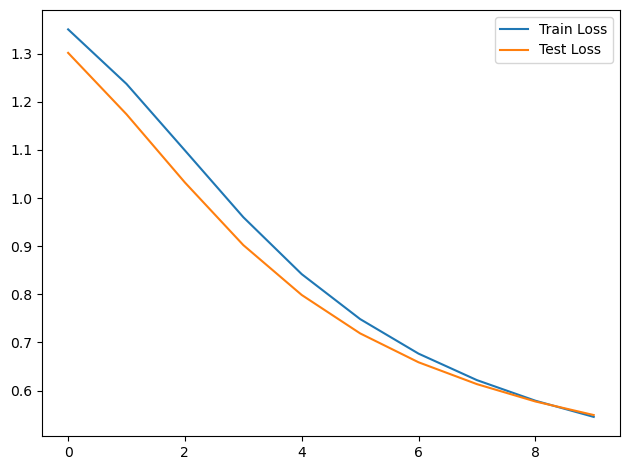

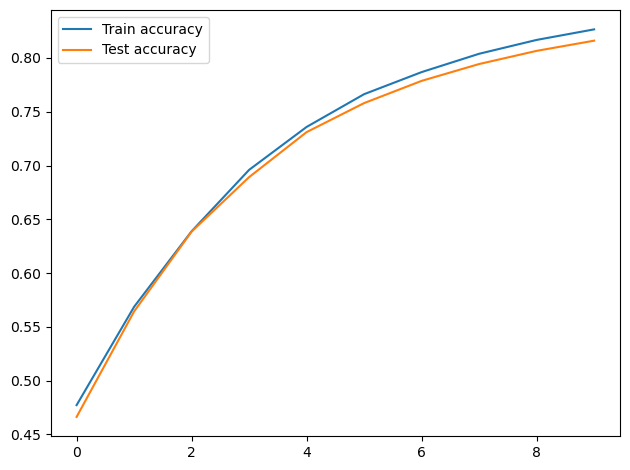

In [98]:
import matplotlib.pyplot as plt
fig,ax1 = plt.subplots()
ax1.plot(result['train_loss'],label = 'Train Loss')
ax1.plot(result['test_loss'],label = 'Test Loss')
plt.legend()
plt.tight_layout()

fig,ax2 = plt.subplots()
ax2.plot(result['train_accuracy'],label = 'Train accuracy')
ax2.plot(result['test_accuracy'],label = 'Test accuracy')
plt.legend()
plt.tight_layout()